## CLIP Process Discovery Integration

### Imports

In [2]:
import os
import cv2
import gc
import random
from datetime import datetime
from PIL import Image
import shutil
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import GridBox, Layout
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score, precision_score, recall_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score, f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import imagehash
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer


# TensorFlow related imports
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# PM4Py related imports
# import pm4py
# from pm4py.objects.conversion.log import converter as log_converter
# from pm4py.algo.discovery.inductive import algorithm as inductive_miner
# from pm4py.objects.conversion.process_tree import converter as pt_converter
# from pm4py.visualization.petri_net import visualizer as pn_visualizer
# from pm4py.visualization.bpmn import visualizer as bpmn_visualizer
# from pm4py.objects.bpmn.exporter import exporter as bpmn_exporter
# from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
# from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
# from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
# from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
# from transformers import CLIPModel, CLIPProcessor, CLIPTokenizer


### Lectura fichero

In [3]:
def read_ui_log_as_dataframe(log_path):
  return pd.read_csv(log_path, sep=";")#, index_col=0)

### Extracción de características

In [4]:
def extract_features_from_images(df, image_col, text_col, image_weight, text_weight, img_dir):
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    combined_features = []

    for _, row in df.iterrows():
        text = row[text_col]
        # Usa os.path.join para construir la ruta completa de la imagen.
        image_path = os.path.join(img_dir, row[image_col])
        
        # Asegúrate de que la imagen exista, de lo contrario lanza un error.
        if not os.path.exists(image_path):
            raise ValueError(f"La imagen no existe en {image_path}")

        # Abre la imagen usando la ruta completa.
        image = Image.open(image_path)
        inputs = processor(text=[text], images=image, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**inputs)

        image_features = outputs.image_embeds.cpu().numpy().flatten() * image_weight
        text_features = outputs.text_embeds.cpu().numpy().flatten() * text_weight
        
        combined_feature = np.hstack((image_features, text_features))
        combined_features.append(combined_feature)

    df['combined_features'] = combined_features

    return df

In [19]:
def extract_features_from_images_with_tokenizer(df, image_col, text_col, image_weight, text_weight, img_dir, log_root, header_txt=False, text_path_col="header_txt"):
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

    combined_features = []

    for _, row in df.iterrows():
        if header_txt:
            txt_path = os.path.join(log_root, "ocr_results", row[text_path_col])
            if not os.path.exists(txt_path):
                raise FileNotFoundError(f"El archivo de texto no existe: {txt_path}")
            with open(txt_path, 'r') as file:
                text = file.read()
        else:
            text = row[text_col]

        print(text)
        # Tokenizar el texto
        input_ids = tokenizer(text, return_tensors="pt", truncation=True)
        
        # Construye la ruta completa de la imagen y asegura que exista.
        image_path = os.path.join(img_dir, row[image_col])
        if not os.path.exists(image_path):
            raise ValueError(f"La imagen no existe en {image_path}")

        # Abre la imagen y la procesa con el modelo CLIP
        image = Image.open(image_path)
        image_inputs = processor(images=[image], return_tensors="pt")

        # Combina las entradas de texto e imagen y pasarlo al modelo
        inputs = {'input_ids': input_ids['input_ids'], 'attention_mask': input_ids['attention_mask'], 'pixel_values': image_inputs['pixel_values']}

        with torch.no_grad():
            outputs = model(**inputs)

        image_features = outputs.image_embeds.cpu().numpy().flatten() * image_weight
        text_features = outputs.text_embeds.cpu().numpy().flatten() * text_weight
        combined_feature = np.hstack((image_features, text_features))
        combined_features.append(combined_feature)

    df['combined_features'] = combined_features
    return df


In [6]:
def extract_hash(df,img_dir,image_col):
    combined_features = []

    for _, row in df.iterrows():
        img3 = Image.open(os.path.join(img_dir, row[image_col]))
        image_three_hash = imagehash.whash(img3)
        combined_features.append(np.array(image_three_hash.hash).flatten())
    
    df['combined_features'] = combined_features

    return df

### Clusterización

In [7]:
def cluster_images(df, n_clusters_range, use_pca, n_components):
    features = np.array(df['combined_features'].tolist())
    
    if use_pca:
        pca = PCA(n_components=n_components)
        features = pca.fit_transform(features)
        print(f"PCA aplicado: {features.shape[1]} componentes retenidos")

    clustering_scores = {
        'n_clusters': [],
        'silhouette_score': [],
        'davies_bouldin_score': [],
        'calinski_harabasz_score': []
    }

    for k in range(*n_clusters_range):
        clustering = AgglomerativeClustering(n_clusters=k).fit(features)
        labels = clustering.labels_

        clustering_scores['n_clusters'].append(k)
        clustering_scores['silhouette_score'].append(silhouette_score(features, labels))
        clustering_scores['davies_bouldin_score'].append(davies_bouldin_score(features, labels))
        clustering_scores['calinski_harabasz_score'].append(calinski_harabasz_score(features, labels))

    # Encuentra el índice del número óptimo de clústeres basado en la mejor puntuación Silhouette
    optimal_index = np.argmax(clustering_scores['silhouette_score'])
    optimal_clusters = clustering_scores['n_clusters'][optimal_index]

    # Ejecutar el clustering con el número óptimo de clústeres
    best_clustering = AgglomerativeClustering(n_clusters=optimal_clusters).fit(features)
    df['activity_label'] = best_clustering.labels_

    # Obtener las métricas para el número óptimo de clústeres
    optimal_metrics = {
        'silhouette_score': clustering_scores['silhouette_score'][optimal_index],
        'davies_bouldin_score': clustering_scores['davies_bouldin_score'][optimal_index],
        'calinski_harabasz_score': clustering_scores['calinski_harabasz_score'][optimal_index]
    }

    return df, clustering_scores, optimal_clusters, optimal_metrics


In [8]:
def eliminar_acciones_duplicadas(df, columna_label='activity_label'):
    while True:
        mascaras_para_eliminar = df[columna_label].eq(df[columna_label].shift())
        if mascaras_para_eliminar.sum() == 0:
            break
        df = df[~mascaras_para_eliminar].reset_index(drop=True)
    return df

### Case configuration

In [62]:
#invoice def (+1 path 'customer path')
log_root = 'logs/invoice_def'
log_path = 'logs/invoice_def/log.csv'
image_col = 'screenshot'
image_dir = 'resources/invoice_def'
text_col = 'header'
timestamp_col = 'timestamp'

In [54]:
# SC50_Rebuild
log_root = 'logs/SC50_Rebuild'
log_path = 'logs/SC50_Rebuild/log.csv'
image_col = 'screenshot'
image_dir = 'resources/SC50_Rebuild'
text_col = 'header'
timestamp_col = 'timestamp'

In [211]:
# SC50_Rebuild_noconfirm
log_path = 'logs/SC50_Rebuild/fake_no_confirm.csv'
image_col = 'screenshot'
image_dir = 'resources/SC50_No_Confirm'
text_col = 'header'
timestamp_col = 'timestamp'

### Execution config

In [46]:
def overwrite_csv(df, file_path):
    """Escribe un DataFrame a un archivo CSV, sobrescribiendo el archivo existente."""
    try:
        if os.path.exists(file_path):
            os.remove(file_path)
        df.to_csv(file_path, index=False)
    except Exception as e:
        print(f"Error al escribir el archivo CSV: {e}")

def move_and_overwrite(source, destination):
    """Mueve un archivo de una ubicación a otra y lo sobrescribe si ya existe."""
    if os.path.exists(destination):
        os.remove(destination)
    shutil.move(source, destination)
    
def clear_caches():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def load_fresh_data():
    return read_ui_log_as_dataframe(log_path)

def accuracy_calculation(df, activity_label, ground_truth_colname='ground_truth'):
    # Obtener las listas únicas de clústeres predichos y ground_truth
    predicted_clusters = df[activity_label].unique()
    true_clusters = df[ground_truth_colname].unique()

    # Crear la matriz de costos
    cost_matrix = np.zeros((len(predicted_clusters), len(true_clusters)))

    for i, pred_cluster in enumerate(predicted_clusters):
        for j, true_cluster in enumerate(true_clusters):
            # Calcular el número de veces que un clúster predicho se asocia a un clúster verdadero
            cost_matrix[i, j] = -((df[activity_label] == pred_cluster) & (df[ground_truth_colname] == true_cluster)).sum()

    # Usar el algoritmo de asignación húngaro para minimizar el costo
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Crear un diccionario de mapeo de clústeres predichos a ground truth
    cluster_mapping = {predicted_clusters[row]: true_clusters[col] for row, col in zip(row_ind, col_ind)}

    # Mapear los clústeres predichos a los clústeres ground truth
    df['mapped_prediction'] = df[activity_label].map(cluster_mapping)

    # Tratar los NaN agregando un -1 si no se asigna etiqueta
    df['mapped_prediction'] = df['mapped_prediction'].fillna(-1)

    # Evaluar la precisión (accuracy)
    f1 = f1_score(df[ground_truth_colname], df['mapped_prediction'], average='macro', zero_division=0)
    print(f"F1-score: {f1}")

    # Evaluar la precisión (precision) y el recall
    precision = precision_score(df[ground_truth_colname], df['mapped_prediction'], average='macro', zero_division=0)
    recall = recall_score(df[ground_truth_colname], df['mapped_prediction'], average='macro', zero_division=0)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    
    return f1, precision, recall

### Lanzar / Guardar ejecución

In [64]:
# Configuraciones iniciales
model = 'clip'
n_clusters_range = (2, 11)
n_components = 0.95
use_pca = False
tokeniza = False #¿Tokenizamos?
header_txt = False #¿Usamos el texto completo?
use_hash = True #¿Usamos hash?

# Directorio principal para los casos de estudio
ground_truth_colname='ground_truth'
case_study_name = "invoice_hash" 
root_dir = os.path.join("executions", case_study_name)
os.makedirs(root_dir, exist_ok=True)

results = []

# Información de las ejecuciones a realizar
executions = [
    {'exec': 1, 'image_weight': 1, 'text_weight': 0},
    {'exec': 2, 'image_weight': 0.8, 'text_weight': 0.2},
    {'exec': 3, 'image_weight': 0.6, 'text_weight': 0.4},
    {'exec': 4, 'image_weight': 0.5, 'text_weight': 0.5},
    {'exec': 5, 'image_weight': 0.4, 'text_weight': 0.6},
    {'exec': 6, 'image_weight': 0.2, 'text_weight': 0.8},
    {'exec': 7, 'image_weight': 0, 'text_weight': 1}
]



In [65]:
for exec in executions:

    df = read_ui_log_as_dataframe(log_path)
    clear_caches()  

    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
        
    exec_dir = f"{case_study_name}_{exec['image_weight']}_{exec['text_weight']}"
    exec_path = os.path.join(root_dir, exec_dir)
    os.makedirs(exec_path, exist_ok=True)

    image_weight = exec['image_weight']
    text_weight = exec['text_weight']
    
    if tokeniza:
        df = extract_features_from_images_with_tokenizer(df, image_col, text_col, image_weight, text_weight, image_dir, log_root, header_txt, text_path_col='header_txt')
    elif use_hash:
        df = extract_hash(df, image_dir, image_col)
    else:
        df = extract_features_from_images(df, image_col, text_col, image_weight, text_weight, image_dir)
    
    df, clustering_scores, optimal_clusters, optimal_metrics = cluster_images(df, n_clusters_range, use_pca, n_components)

    f1, precision, recall = accuracy_calculation(df, 'activity_label', ground_truth_colname)

    df.to_csv(os.path.join(exec_path, 'df.csv'), index=False)


    results.append({
        'exec': exec['exec'],
        'image_weight': image_weight,
        'text_weight': text_weight,
        'Silhouette': optimal_metrics['silhouette_score'],
        'Davies-Bouldin': optimal_metrics['davies_bouldin_score'],
        'Calinski-Harabasz': optimal_metrics['calinski_harabasz_score'],
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
    })

results_df = pd.DataFrame(results)
overwrite_csv(results_df, os.path.join(root_dir, 'resultados.csv'))

df.head()


F1-score: 0.664779893882061
Precision: 0.7518518518518519
Recall: 0.6222222222222222
F1-score: 0.664779893882061
Precision: 0.7518518518518519
Recall: 0.6222222222222222
F1-score: 0.664779893882061
Precision: 0.7518518518518519
Recall: 0.6222222222222222
F1-score: 0.664779893882061
Precision: 0.7518518518518519
Recall: 0.6222222222222222
F1-score: 0.664779893882061
Precision: 0.7518518518518519
Recall: 0.6222222222222222
F1-score: 0.664779893882061
Precision: 0.7518518518518519
Recall: 0.6222222222222222
F1-score: 0.664779893882061
Precision: 0.7518518518518519
Recall: 0.6222222222222222


,id,screenshot,timestamp,header,header_txt,ground_truth,combined_features,activity_label,mapped_prediction
0,1,1_img.png,10:00:29,Odoo - Discuss,1_ocr.txt,1,"[False, False, False, False, False, False, Fal...",6,1.0
1,2,2_img.png,10:00:31,Odoo - Invoices,2_ocr.txt,2,"[False, False, False, False, False, False, Fal...",7,2.0
2,3,3_img.png,10:00:33,Odoo - Customer Payments,3_ocr.txt,3,"[False, False, False, False, False, False, Fal...",2,3.0
3,4,4_img.png,10:00:35,Odoo - Draft Payment,4_ocr.txt,4,"[False, False, False, False, False, False, Fal...",4,4.0
4,5,5_img.png,10:00:37,Odoo - PBNK1/2024/00023,5_ocr.txt,5,"[False, False, False, False, False, False, Fal...",4,4.0


### Visualizer

In [36]:
def load_image(image_path):
    """Carga una imagen desde una ruta de archivo y la convierte en un array de numpy."""
    try:
        with Image.open(image_path) as img:
            return np.array(img)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return np.zeros((100, 100, 3))  # Devuelve una imagen en blanco si no se puede cargar la imagen

def visualize_clusters(df, cluster_numbers, ground_truth_colname='ground_truth', image_colname='screenshot', image_dir='', max_images_per_cluster=10):
    """
    Visualiza imágenes de clústeres seleccionados en un DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame que contiene las imágenes y las etiquetas de clústeres.
    - cluster_numbers (list): Lista de números de clústeres a visualizar.
    - ground_truth_colname (str): Nombre de la columna que contiene las etiquetas de clústeres.
    - image_colname (str): Nombre de la columna que contiene las rutas a las imágenes.
    - image_dir (str): Directorio base donde se encuentran las imágenes.
    - max_images_per_cluster (int): Número máximo de imágenes a mostrar por clúster.
    """
    # Filtrar el DataFrame para solo incluir los clústeres seleccionados
    filtered_df = df[df[ground_truth_colname].isin(cluster_numbers)]
    
    # Configurar la figura para visualizar las imágenes
    num_clusters = len(cluster_numbers)
    num_rows = min(max_images_per_cluster, len(filtered_df))
    fig, axes = plt.subplots(num_rows, num_clusters, figsize=(num_clusters * 3, num_rows * 3))
    
    if num_clusters == 1:
        axes = np.expand_dims(axes, axis=1)  # Asegurarse de que 'axes' sea bidimensional

    for i, cluster in enumerate(cluster_numbers):
        cluster_df = filtered_df[filtered_df[ground_truth_colname] == cluster]
        
        for j, (_, row) in enumerate(cluster_df.iterrows()):
            if j >= max_images_per_cluster:
                break
            image_path = os.path.join(image_dir, row[image_colname])
            img = load_image(image_path)
            ax = axes[j, i]
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(f'Cluster {cluster}')
    
    plt.tight_layout()
    plt.show()

In [42]:
# Configuración de los directorios y nombres de columnas
log_path = 'logs/SC50_Rebuild/fake.csv'
image_col = 'screenshot'
image_dir = 'resources/SC50_Rebuild_POPUP'
ground_truth_col = 'ground_truth'
cluster_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Seleccionar los clústeres a visualizar

Error loading image resources/invoice_def_POPUP/1_img.png: [Errno 2] No such file or directory: 'resources/invoice_def_POPUP/1_img.png'
Error loading image resources/invoice_def_POPUP/8_img.png: [Errno 2] No such file or directory: 'resources/invoice_def_POPUP/8_img.png'
Error loading image resources/invoice_def_POPUP/15_img.png: [Errno 2] No such file or directory: 'resources/invoice_def_POPUP/15_img.png'
Error loading image resources/invoice_def_POPUP/19_img.png: [Errno 2] No such file or directory: 'resources/invoice_def_POPUP/19_img.png'
Error loading image resources/invoice_def_POPUP/26_img.png: [Errno 2] No such file or directory: 'resources/invoice_def_POPUP/26_img.png'
Error loading image resources/invoice_def_POPUP/30_img.png: [Errno 2] No such file or directory: 'resources/invoice_def_POPUP/30_img.png'
Error loading image resources/invoice_def_POPUP/37_img.png: [Errno 2] No such file or directory: 'resources/invoice_def_POPUP/37_img.png'
Error loading image resources/invoice_

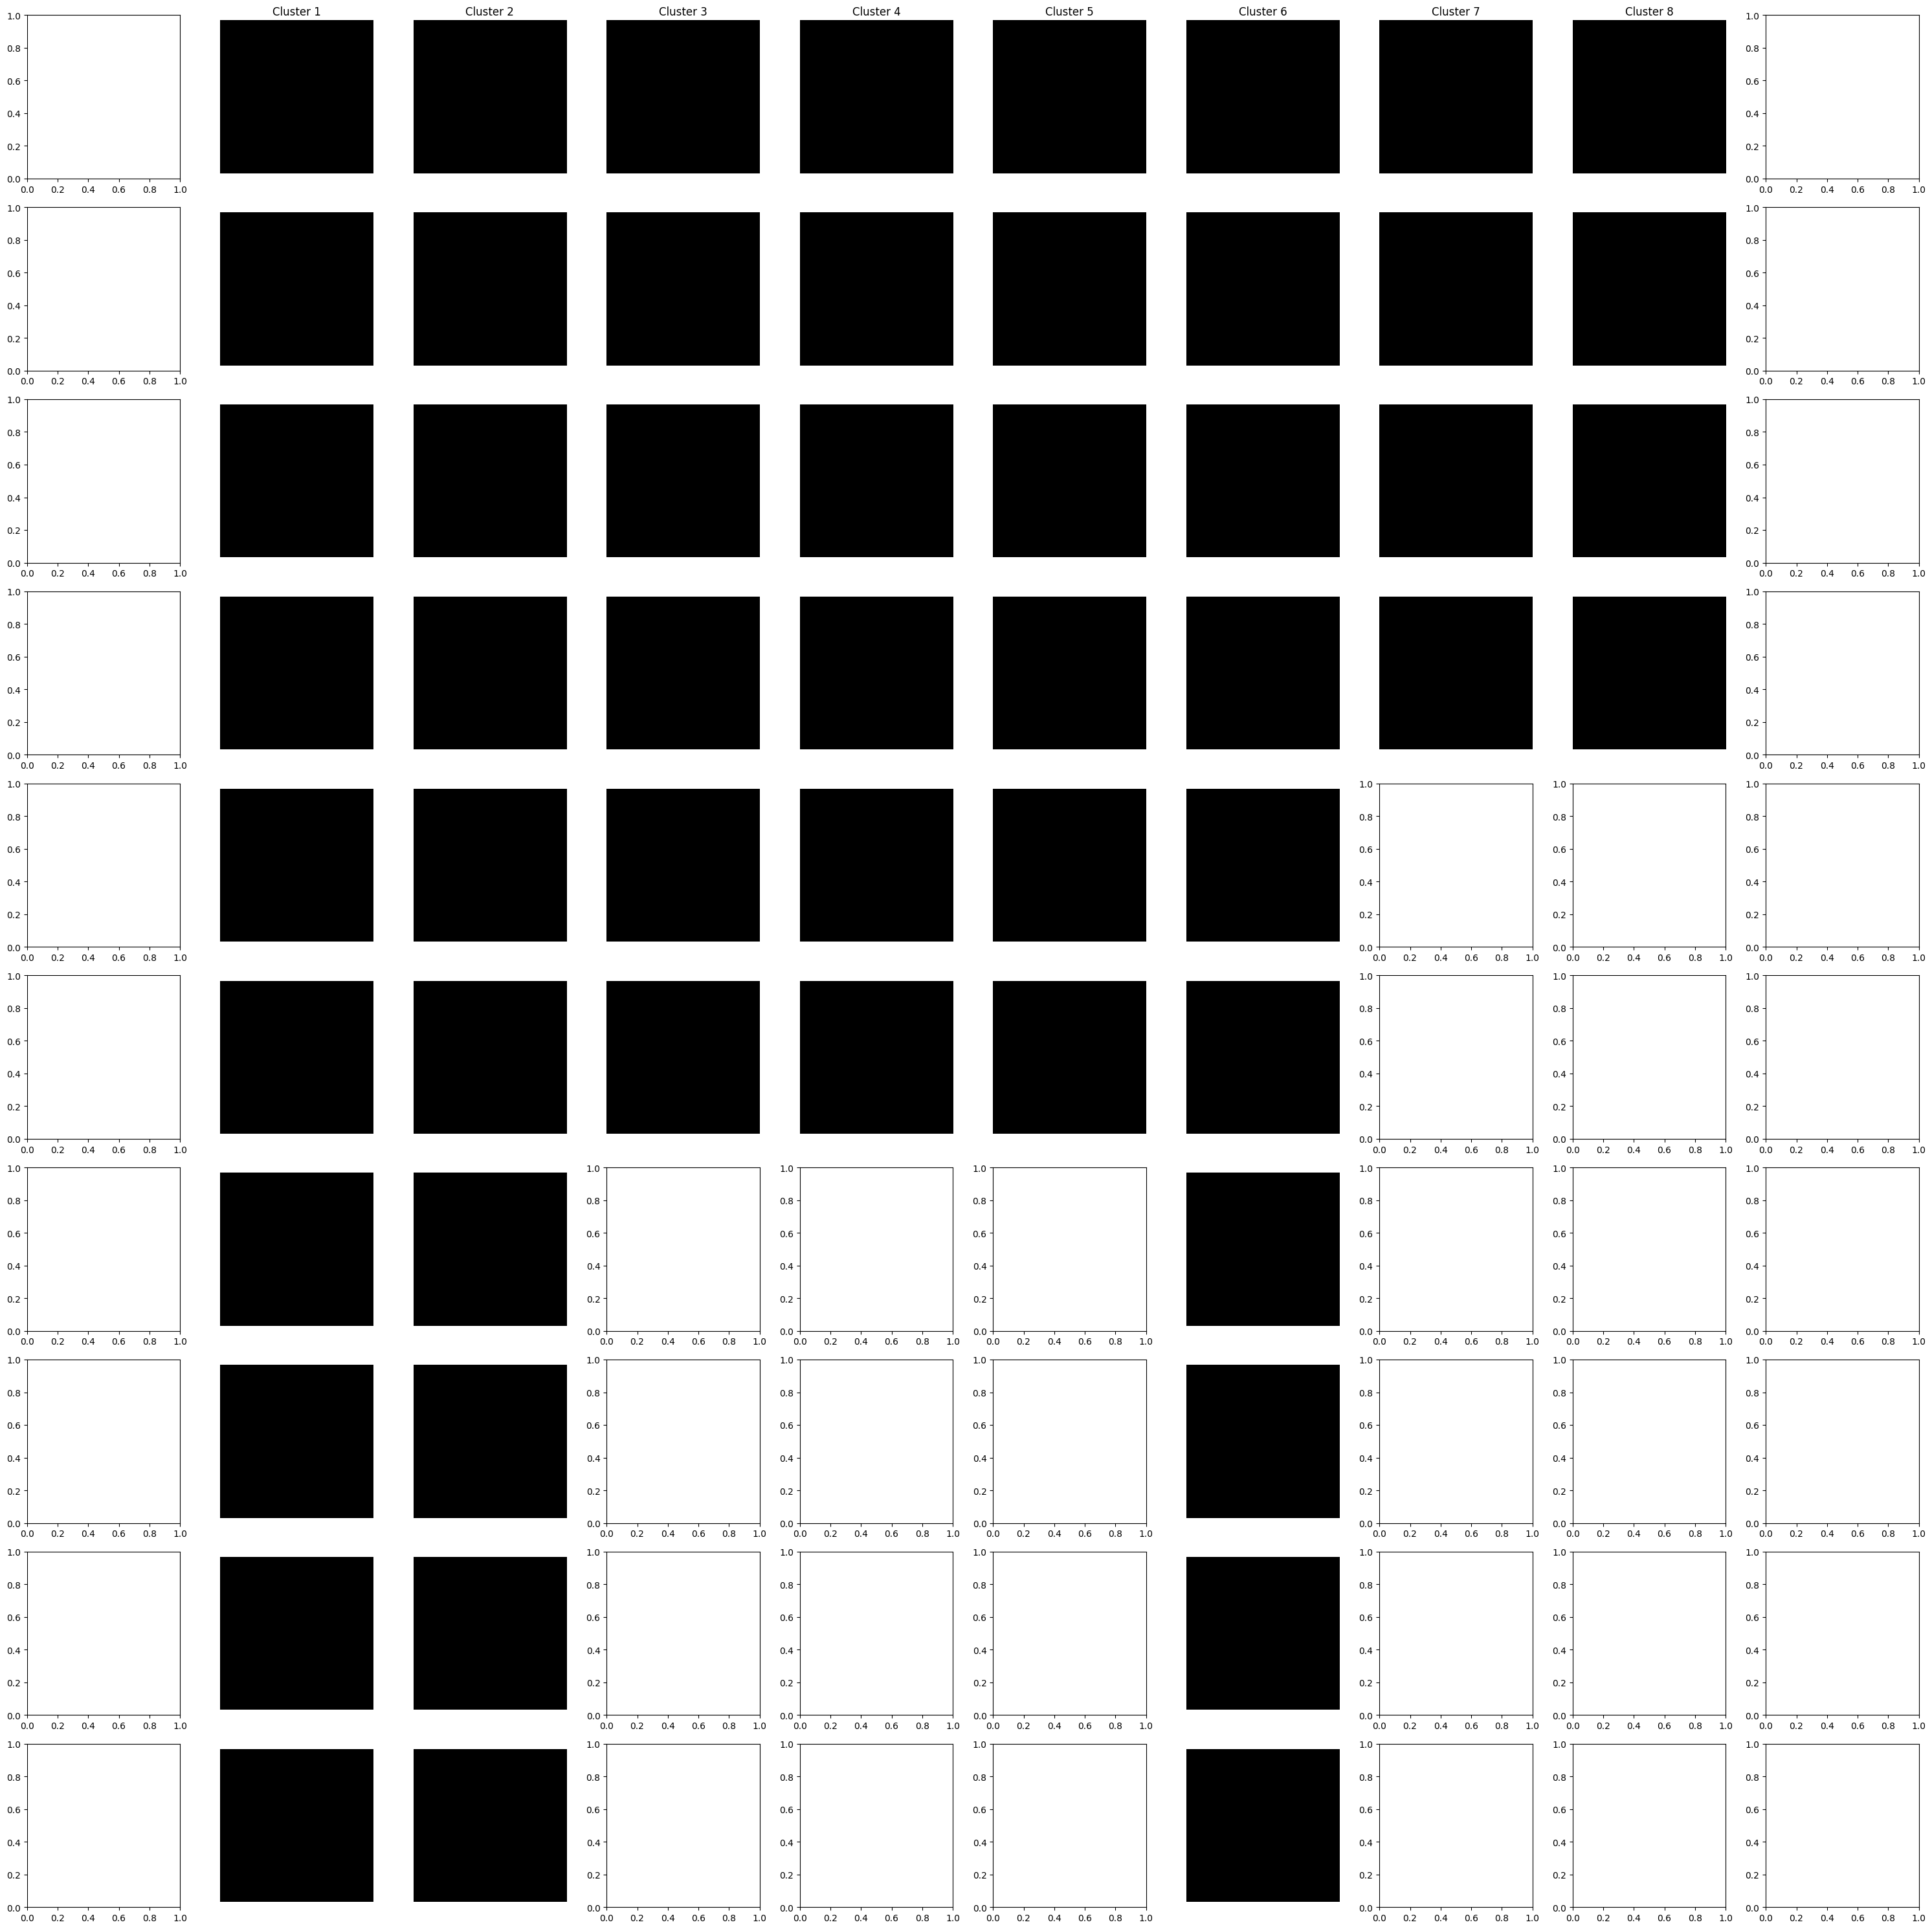

In [39]:
visualize_clusters(df, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ground_truth_colname, image_col, image_dir, max_images_per_cluster=10)